In [1]:
# Real life data

import logging
import json
import threading
import itertools
import pandas as pd  
import numpy as np  
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.dbtables import FileModelStore
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.aggregate import (Minimum, Mean, Maximum)
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from mmfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore, HistogramAggregator)
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, r2_score

import scipy as sp
import scipy.fftpack
import skimage as ski

from skimage import util as skiutil # for nifty windowing
import pyod as pyod
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

In [2]:
'''
with open('credentials_as_monitor_demo.json', encoding='utf-8') as F:
    credentials = json.loads(F.read())


db_schema=None           
fm = FileModelStore()
db = Database(credentials=credentials) # , model_store=fm)
print (db)
'''
db_schema=None
class DatabaseDummy:
    tenant_id = '###_IBM_###'
    db_type = 'db2'
    model_store = FileModelStore()
    def _init(self):
        return

db = DatabaseDummy()
        
print (db.tenant_id)

2021-10-19T11:13:53.887 INFO iotfunctions.dbtables.__init__ Init FileModelStore with path: 
###_IBM_###


In [3]:
df_input = pd.read_csv('iot_vacuum_rawHouseAir.csv', parse_dates=['rcv_timestamp_utc'])
df_input2 = pd.read_csv('dm_vacuum_KMeanScore.csv', parse_dates=['timestamp'])
df_input['timestamp'] = df_input['rcv_timestamp_utc']
df_input['score'] = df_input2['value_n']
df_input = df_input.dropna()
df_input = df_input.set_index(['timestamp']).sort_index()

df_input = df_input[['houseair','score']]
df_input
df_snippet = df_input.head(370)

<ipython-input-4-fe6fe84ba25d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_snippet['boundary'] = 50


<AxesSubplot:xlabel='timestamp'>

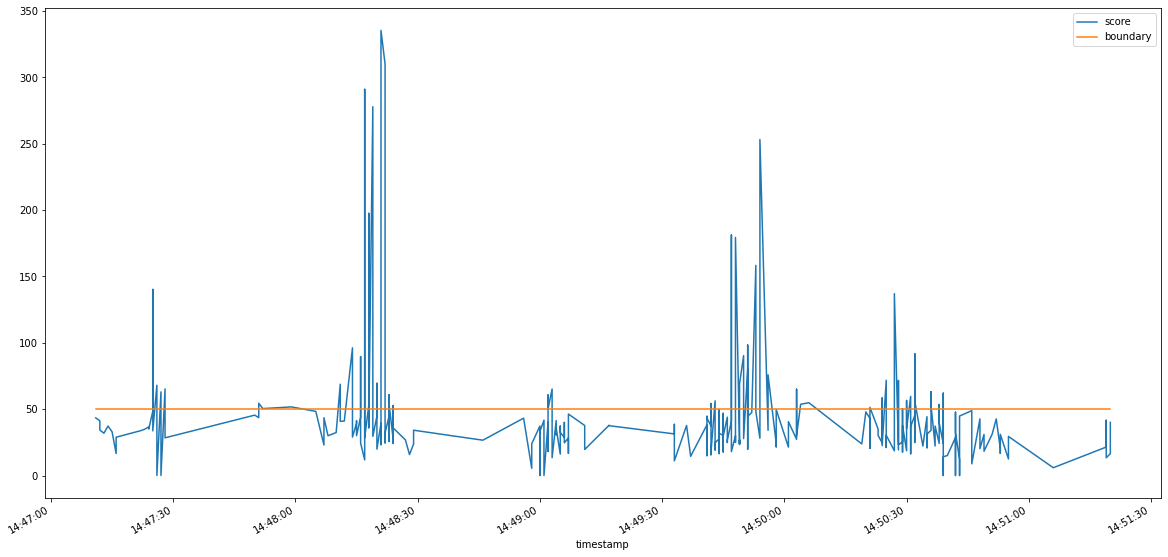

In [4]:
df_snippet['boundary'] = 50
df_snippet[['score','boundary']].plot(figsize=(20,10))

In [5]:
df_input['entity'] = 'MyRoom'
df_input = df_input.reset_index().set_index(['entity','timestamp'])

In [6]:
df_input.reset_index()

,entity,timestamp,houseair,score
0,MyRoom,2020-04-08 14:47:11,96.830549,43.422370
1,MyRoom,2020-04-08 14:47:12,98.578882,41.174747
2,MyRoom,2020-04-08 14:47:12,96.481989,34.242996
3,MyRoom,2020-04-08 14:47:13,95.956382,31.865686
4,MyRoom,2020-04-08 14:47:14,97.140380,37.262580
...,...,...,...,...
581,MyRoom,2020-04-08 14:53:05,94.617469,39.894424
582,MyRoom,2020-04-08 14:53:05,95.707411,31.156020
583,MyRoom,2020-04-08 14:53:06,99.840338,31.882555
584,MyRoom,2020-04-08 14:53:06,98.916377,35.073260


In [7]:
df_input2 = df_input.copy()

Indexlist = df_input2.index.to_list()
Indexlist_new = []
for p in Indexlist:
    p_new = ('MyRoom2', p[1])
    Indexlist_new.append(p_new)
df_input2.index = Indexlist_new
df_input = pd.concat([df_input,df_input2])
df_input


houseair      score
entity  timestamp                                
MyRoom  2020-04-08 14:47:11  96.830549  43.422370
        2020-04-08 14:47:12  98.578882  41.174747
        2020-04-08 14:47:12  96.481989  34.242996
        2020-04-08 14:47:13  95.956382  31.865686
        2020-04-08 14:47:14  97.140380  37.262580
...                                ...        ...
MyRoom2 2020-04-08 14:53:05  94.617469  39.894424
        2020-04-08 14:53:05  95.707411  31.156020
        2020-04-08 14:53:06  99.840338  31.882555
        2020-04-08 14:53:06  98.916377  35.073260
        2020-04-08 14:53:07  96.454325  34.824245

[1172 rows x 2 columns]

In [8]:
from mmfunctions.bif import (AggregateWithExpression, AggregateTimeInState)



In [9]:
df_input

houseair      score
entity  timestamp                                
MyRoom  2020-04-08 14:47:11  96.830549  43.422370
        2020-04-08 14:47:12  98.578882  41.174747
        2020-04-08 14:47:12  96.481989  34.242996
        2020-04-08 14:47:13  95.956382  31.865686
        2020-04-08 14:47:14  97.140380  37.262580
...                                ...        ...
MyRoom2 2020-04-08 14:53:05  94.617469  39.894424
        2020-04-08 14:53:05  95.707411  31.156020
        2020-04-08 14:53:06  99.840338  31.882555
        2020-04-08 14:53:06  98.916377  35.073260
        2020-04-08 14:53:07  96.454325  34.824245

[1172 rows x 2 columns]

In [10]:
from mmfunctions.bif import (AggregateWithExpression, AggregateTimeInState, StateTimePreparation)
EngineLogging.configure_console_logging(logging.DEBUG)
acii = StateTimePreparation(source='score', state_name='> 50', name='score_out')

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}
et = acii._build_entity_type(columns = [Column('changed',Float())], **jobsettings)

df_input = acii.execute(df=df_input)

2021-10-19T11:14:14.642 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2021-10-19T11:14:14.644 INFO mmfunctions.bif.__init__ StateTimePrep _init
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abort_on_fail', '_add_explicit_outputs', '_allow_empty_df', '_build_entity_type', '_calc', '_coallesce_columns', '_end_date', '_entity_scd_dict', '_entity_type', '_getJsonDataType', '_getJsonSchema', '_getMetadata', '_get_arg_metadata', '_get_data_scope', '_get_scd_history', '_get_series', '_inferOutputs', '_infer_array_source', '_infer_type', '_input_set', '_inputs', '_is_instance_level_logged', '_metadata_params', '_output_items_extended_metadata

In [14]:
new = df_input['score_out'].str.split(pat=',', n=1, expand=True).astype(int)
#df_input['score1'] = new[0]
#new[0].values
df_input['score_out']

entity   timestamp          
MyRoom   2020-04-08 14:47:11    -1,1586357231
         2020-04-08 14:47:12     0,1586357232
         2020-04-08 14:47:12     0,1586357232
         2020-04-08 14:47:13     0,1586357233
         2020-04-08 14:47:14     0,1586357234
                                    ...      
MyRoom2  2020-04-08 14:53:05    -1,1586357585
         2020-04-08 14:53:05     0,1586357585
         2020-04-08 14:53:06     0,1586357586
         2020-04-08 14:53:06     0,1586357586
         2020-04-08 14:53:07     0,1586357587
Name: score_out, Length: 1172, dtype: object

In [20]:
from iotfunctions.base import BaseSimpleAggregator
from iotfunctions.aggregate import (Aggregation, AggregateWithCalculation, add_simple_aggregator_execute)

# Run Monitoring's anomaly detector functions
EngineLogging.configure_console_logging(logging.DEBUG)

func = AggregateTimeInState #(input_items=['score'], output_items=['score_out'], expression='{GROUP}.max()')

# prepare parameter list
params_dict = {}
params_dict['source'] = 'score_out'
params_dict['name'] = 'score_out2'
#params_dict['state_name'] = 'blah'

# replace aggregate call with 'execute_AggregateWithExpression'
func_name = 'execute_AggregateTimeInState'
add_simple_aggregator_execute(func, func_name)

func_clos = getattr(func(**params_dict), func_name)


# set up an Aggregation thingy with the entity index, timestamp index, 
# desired granularity and a (short) chain of aggregators
# granularity = frequency, dimension(s), include entity, entity id
aggii = Aggregation(None, ids=['entity'], timestamp='timestamp', granularity=('2T', None, True, 0), 
                    simple_aggregators=[(['score_out'], func_clos, 'Seconds>50')])
print(aggii)

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}
et = aggii._build_entity_type(columns = [Column('changed',Float())], **jobsettings)

df_agg = aggii.execute(df=df_input)

2021-10-19T11:18:55.397 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2021-10-19T11:18:55.399 INFO mmfunctions.bif.__init__ AggregateTimeInState _init
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abort_on_fail', '_add_explicit_outputs', '_allow_empty_df', '_build_entity_type', '_calc', '_coallesce_columns', '_end_date', '_entity_scd_dict', '_entity_type', '_getJsonDataType', '_getJsonSchema', '_getMetadata', '_get_arg_metadata', '_get_data_scope', '_get_scd_history', '_get_series', '_inferOutputs', '_infer_array_source', '_infer_type', '_input_set', '_inputs', '_is_instance_level_logged', '_metadata_params', '_output_items_extended_m

In [21]:
df_agg

Seconds>50
entity  timestamp                      
MyRoom  2020-04-08 14:46:00           8
        2020-04-08 14:48:00           9
        2020-04-08 14:50:00          28
        2020-04-08 14:52:00          11
MyRoom2 2020-04-08 14:46:00           8
        2020-04-08 14:48:00           9
        2020-04-08 14:50:00          28
        2020-04-08 14:52:00          11

In [24]:
df_agg.loc['MyRoom']['Seconds>50'].sum()

56

In [25]:
#np.count_nonzero(df_input['score'].values > 50)

In [15]:
(df_input['score'].values < 10000).argmax()

0

In [27]:
df_input

houseair      score      score_out  changed
entity  timestamp                                                        
MyRoom  2020-04-08 14:47:11  96.830549  43.422370  -1,1586357231        1
        2020-04-08 14:47:12  98.578882  41.174747   0,1586357232        0
        2020-04-08 14:47:12  96.481989  34.242996   0,1586357232        0
        2020-04-08 14:47:13  95.956382  31.865686   0,1586357233        0
        2020-04-08 14:47:14  97.140380  37.262580   0,1586357234        0
...                                ...        ...            ...      ...
MyRoom2 2020-04-08 14:53:05  94.617469  39.894424  -1,1586357585       -1
        2020-04-08 14:53:05  95.707411  31.156020   0,1586357585        0
        2020-04-08 14:53:06  99.840338  31.882555   0,1586357586        0
        2020-04-08 14:53:06  98.916377  35.073260   0,1586357586        0
        2020-04-08 14:53:07  96.454325  34.824245   0,1586357587        0

[1172 rows x 4 columns]

In [28]:
from iotfunctions.base import BaseSimpleAggregator
from iotfunctions.aggregate import (Aggregation, AggregateWithCalculation, add_simple_aggregator_execute)

# Run Monitoring's anomaly detector functions
EngineLogging.configure_console_logging(logging.DEBUG)

func = AggregateWithExpression #(input_items=['score'], output_items=['score_out'], expression='{GROUP}.max()')

# prepare parameter list - count all elements hotter than 100 degrees
params_dict = {}
params_dict['source'] = 'houseair'
params_dict['name'] = 'ha_gt_100'
#params_dict['expression'] = '(x>100).max()'
params_dict['expression'] = '(x>100).astype(int).sum()'


# replace aggregate call with 'execute_AggregateWithExpression'
func_name = 'execute_AggregateWithExpression'
add_simple_aggregator_execute(func, func_name)

func_clos = getattr(func(**params_dict), func_name)


# set up an Aggregation thingy with the entity index, timestamp index, 
# desired granularity and a (short) chain of aggregators
# the actual expression doesn't matter
aggii = Aggregation(None, ids=['entity'], timestamp='timestamp', granularity=('T', None, True, 16623), 
                    simple_aggregators=[('houseair', func_clos, '(x>100).count()')])

print(aggii)

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}
et = aggii._build_entity_type(columns = [Column('changed',Float())], **jobsettings)

t = aggii.execute(df=df_input)

'''
021-02-24 04:57:14 PM [PID 1] [DEBUG  ] 
analytics_service.api.Aggregation.__init__ : aggregation_ids=['id'],
aggregation_timestamp=evt_timestamp, 
aggregation_simple_aggregators=[('rms_x', <bound method add_simple_aggregator_execute.<locals>.fn of
<iotfunctions.aggregate.Maximum object at 0x7fc791142390>>, 'rms_x_HourlyPerformance_max'),..
aggregation_complex_aggregators=[], aggregation_direct_aggregators=[], 
aggregation_frequency=H, aggregation_groupby=('Pump',), 
aggregation_entityFirst=True
'''

2021-09-17T12:37:09.993 DEBUG iotfunctions.enginelog.configure_console_logging Console logging has been configured. Level = 10
2021-09-17T12:37:09.997 INFO mmfunctions.bif.__init__ AggregateWithExpression _init
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abort_on_fail', '_add_explicit_outputs', '_allow_empty_df', '_build_entity_type', '_calc', '_coallesce_columns', '_end_date', '_entity_scd_dict', '_entity_type', '_getJsonDataType', '_getJsonSchema', '_getMetadata', '_get_arg_metadata', '_get_data_scope', '_get_scd_history', '_get_series', '_inferOutputs', '_infer_array_source', '_infer_type', '_input_set', '_inputs', '_is_instance_level_logged', '_metadata_params', '_output_items_extende

2021-09-17T12:37:10.062 INFO iotfunctions.aggregate.Aggregation.execute after simple aggregation function - sources {'houseair|execute_AggregateWithExpression': '(x>100).count()'}
2021-09-17T12:37:10.064 DEBUG iotfunctions.util.log_data_frame aggregation_df_agg = (5, 1) 
+--------------------------------------------------------+-------------------+
|                                                        |   (x>100).count() |
|--------------------------------------------------------+-------------------|
| ('MyRoom', Timestamp('2020-04-08 14:47:00', freq='T')) |                 1 |
| ('MyRoom', Timestamp('2020-04-08 14:48:00', freq='T')) |                 2 |
| ('MyRoom', Timestamp('2020-04-08 14:49:00', freq='T')) |                 3 |
| ('MyRoom', Timestamp('2020-04-08 14:50:00', freq='T')) |                 3 |
| ('MyRoom', Timestamp('2020-04-08 14:51:00', freq='T')) |                 3 |
+--------------------------------------------------------+-------------------+
2021-09-17T12:37:

"\n021-02-24 04:57:14 PM [PID 1] [DEBUG  ] \nanalytics_service.api.Aggregation.__init__ : aggregation_ids=['id'],\naggregation_timestamp=evt_timestamp, \naggregation_simple_aggregators=[('rms_x', <bound method add_simple_aggregator_execute.<locals>.fn of\n<iotfunctions.aggregate.Maximum object at 0x7fc791142390>>, 'rms_x_HourlyPerformance_max'),..\naggregation_complex_aggregators=[], aggregation_direct_aggregators=[], \naggregation_frequency=H, aggregation_groupby=('Pump',), \naggregation_entityFirst=True\n"

In [29]:
t

(x>100).count()
entity  timestamp                           
MyRoom  2020-04-08 14:47:00              1.0
        2020-04-08 14:48:00              2.0
        2020-04-08 14:49:00              3.0
        2020-04-08 14:50:00              3.0
        2020-04-08 14:51:00              3.0
        2020-04-08 14:52:00              2.0
        2020-04-08 14:53:00              0.0
MyRoom2 2020-04-08 14:47:00              1.0
        2020-04-08 14:48:00              2.0
        2020-04-08 14:49:00              3.0
        2020-04-08 14:50:00              3.0
        2020-04-08 14:51:00              3.0
        2020-04-08 14:52:00              2.0
        2020-04-08 14:53:00              0.0

In [52]:
df_in1 = pd.read_csv('/home/markus/src/com.ibm.monitorvnext.functions.prototype/src/test/resources/AzureAnomalyScores.csv')
df_in2 = pd.read_csv('/home/markus/src/com.ibm.monitorvnext.functions.prototype/src/test/resources/AzureAnomalysample.csv', parse_dates=['timestamp'])
df_in1['timetick'] = pd.to_datetime(df_in1['timetick']/1000, unit='s')
df_in1 = df_in1.set_index('timetick')
df_in2 = df_in2.set_index('timestamp')

<AxesSubplot:xlabel='timestamp'>

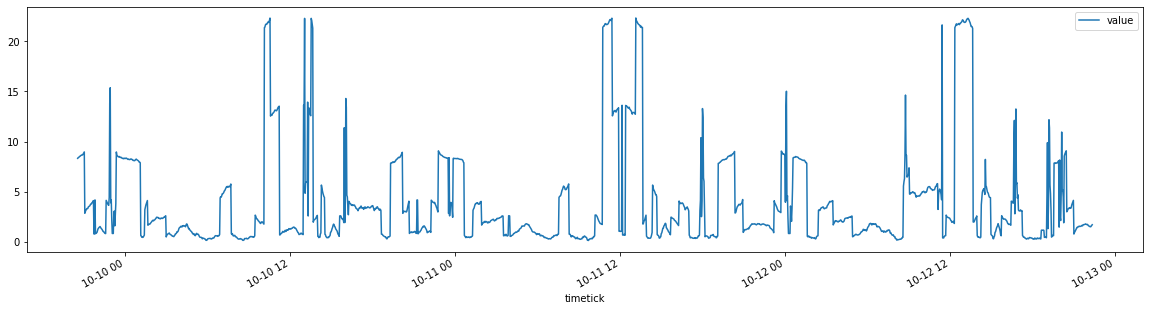

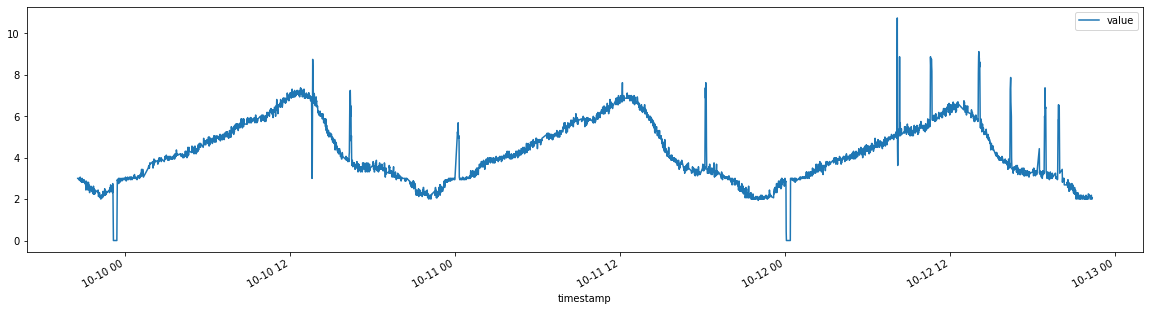

In [53]:
df_in1.plot(figsize=(20,5))
df_in2.plot(figsize=(20,5))


<AxesSubplot:xlabel='timestamp'>

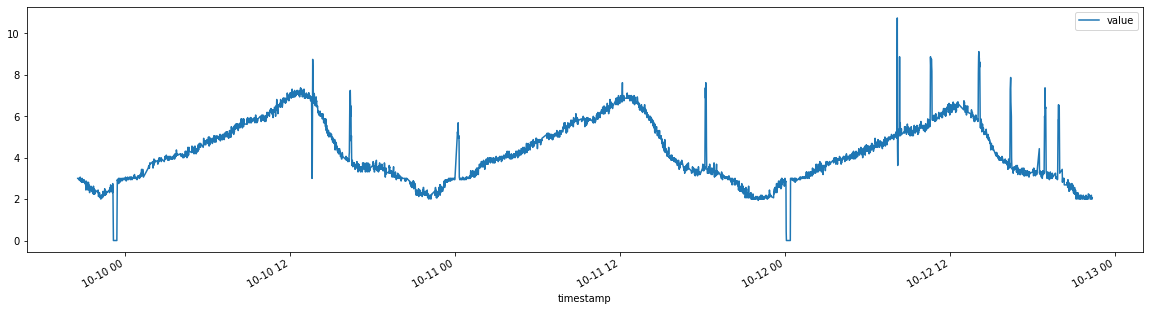

In [120]:
df_in2.plot(figsize=(20,5))